In [ ]:
#Install
#!pip install --upgrade git+https://github.com/openai/gym
#!pip install gym[atari]
#!pip install --upgrade gym[atari]
#!pip install gymnasium[all]
!pip install gym[accept-rom-license]
!pip install ale-py
#!pip install swig
#!pip install Box2D
!pip install pyglet
!pip install torch --ignore-installed TBB --user
!pip install autorom
!AutoROM --accept-license




In [ ]:

#!pip uninstall  typing-extensions

#!pip install -U typing-extensions



In [2]:
# Import
%matplotlib inline
#import gymnasium as gym
import gym
import ale_py
#from ale_py import ALEInterface
#ale = ALEInterface()
#import itertools
#import pygame
import matplotlib
import numpy as np
import pandas as pd
import sys
import time
from matplotlib import pyplot as plt
from collections import defaultdict
matplotlib.style.use('ggplot')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.multiprocessing as mp
import os
#os.environ["OMP_NUM_THREADS"] = "0"


In [3]:
# Create environment
#from ale_py.roms import Assault
#ale.loadROM(Assault)
#env = gym.make('ALE/Assault-v5', render_mode='human')
#env = gym.make('ALE/Assault-v5', render_mode='rgb_array') # this wont show environment so the code will be faster
#env = gym.make('ALE/Assault-ram-v5', render_mode='human')
env = gym.make('ALE/Assault-ram-v5', render_mode='rgb_array')
if 'render_fps' not in env.metadata:
    env.metadata['render_fps'] = 60  # Set this to your desired fps
# Use the play utility to interact with the environment using your keyboard
#from gym.utils import play
#play.play(env)

env.reset()
env.render()
time.sleep(0.1)

In [3]:
env.step(1)
# state, action, terminated?, truncated?, info

E:\Anaconda\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


(array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  96, 254,
          0,   0,   0,   6, 100, 100, 100,   0, 198,   0,   0,   0, 253,
          0,   0, 192,   0, 136, 252,   2,  66, 194,  66, 194,  51, 194,
          6, 188, 255,   0,  25,   0, 253,   0, 253, 128,  64, 128, 128,
         64, 128,   0,   0,   0,   0,   0,   0,  28,  28,  17,  17,   0,
        253,   0, 127,  51,  36,  64,  19,  24,   0, 253,   0,   0,   0,
          0,   0,  66, 194,   0, 254,   0, 254,   0, 254,   0, 254,   0,
        254, 144,  60,   0,   0,   0,   0,   0,  80, 254,   4,  50,  72,
          0,  10,   0,   8,   0,   0, 255, 248,   0,   0,  64,   0, 154,
          0,   0,   0, 248, 251,  15, 252,  64, 251,   0, 245], dtype=uint8),
 0.0,
 False,
 False,
 {'lives': 4, 'episode_frame_number': 4, 'frame_number': 4})

In [4]:
# Allowed Actions
#0: Push cart to the left
#1: Push cart to the right

# Let us take a few actions and get familiar with the environment
print('We started here')
env.reset()
env.render()

# Taking random actions
print('Let us take No operation action twice')
env.step(0)
env.step(0)
time.sleep(1)
#print('Two up actions')
#env.step(1)
#env.step(1)
#time.sleep(1)
print('Two Fire actions')
env.step(2)
env.step(2)
time.sleep(1)
print('Two Right actions')
env.step(3)
env.step(3)
time.sleep(1)
print('Three left actions')
env.step(4)
env.step(4)
env.step(4)
time.sleep(1)
print('Four Right-fire  actions')
env.step(5)
env.step(5)
env.step(5)
env.step(5)
time.sleep(1)
print('Four left-fire actions')
env.step(6)
env.step(6)
env.step(6)
state_features=env.step(6)[0]
print(state_features.shape)
env.render()

env.close()

We started here
Let us take No operation action twice
Two Fire actions
Two Right actions
Three left actions
Four Right-fire  actions
Four left-fire actions
(128,)


In [4]:
# A helper function for plotting the comparision graphs between two or more algorithms.
# You need not understand this code.
# Just look at the next cell to understand how to use it.

def plot_episode_reward(a, stats, smoothing_window=10, noshow=False):
    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(7,3))
    for stat in stats:
        rewards_smoothed = pd.Series(stat).rolling(smoothing_window, min_periods=smoothing_window).mean()
        plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Moving Average Episode Reward")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    plt.legend(a)
    if noshow:
        plt.close(fig2)
    else:
        plt.show(fig2)

In [5]:
from A3Cworker import A3CNet, A3CWorker, A3CSharedAdam
def async_adv_actor_crtic(env,GAMMA,GLOBAL_UPDATE_ITER,local_iter, MAX_EP,learning_rate,env_name):
    N_S = env.observation_space.shape[0]
    N_A = env.action_space.n

    gnet = A3CNet(N_S, N_A)        # global network
    gnet.share_memory()         # share the global parameters in multiprocessing
    opt = A3CSharedAdam(gnet.parameters(), lr=learning_rate)      # global optimizer
    global_ep, global_ep_r, res_queue = mp.Value('i', 0), mp.Value('d', 0.), mp.Queue()

    # parallel training
    print("NUmber of parallel workers")
    print(mp.cpu_count())
    workers = [A3CWorker(gnet, opt, global_ep, global_ep_r, res_queue, i,env_name,N_S,N_A,GLOBAL_UPDATE_ITER,local_iter, MAX_EP,GAMMA,learning_rate) for i in range(mp.cpu_count())]
    print(workers)
    [w.start() for w in workers]
    res = []                    # record episode reward to plot
    while True:
        r = res_queue.get()
        if r is not None:
            res.append(r)
            #print(r)
            #print("found res")
        else:
            break
    [w.join() for w in workers]
    return res

In [5]:
from DQNworker import DQNet, DQNWorker, DQNSharedAdam
def async_deep_q_learning(env,GAMMA,GLOBAL_UPDATE_ITER,local_iter, MAX_EP,learning_rate,epsilon,env_name):
    N_S = env.observation_space.shape[0]
    N_A = env.action_space.n

    gnet = DQNet(N_S, N_A)        # global network
    gnet.share_memory()         # share the global parameters in multiprocessing
    opt = DQNSharedAdam(gnet.parameters(), lr=learning_rate)      # global optimizer
    global_ep, global_ep_r, res_queue = mp.Value('i', 0), mp.Value('d', 0.), mp.Queue()

    # parallel training
    print("NUmber of parallel workers")
    print(mp.cpu_count())
    workers = [DQNWorker(gnet, opt, global_ep, global_ep_r, res_queue, i,env_name,N_S,N_A,GLOBAL_UPDATE_ITER,local_iter, MAX_EP,GAMMA,epsilon,learning_rate) for i in range(mp.cpu_count())]
    print(workers)
    [w.start() for w in workers]
    res = []                    # record episode reward to plot
    while True:
        r = res_queue.get()
        if r is not None:
            res.append(r)
            #print(r)
            #print("found res")
        else:
            break
    [w.join() for w in workers]
    return res

In [6]:
from PGQLworker import PGQLNet, PGQLWorker, PGQLSharedAdam
def async_PGQL(env,GAMMA,GLOBAL_UPDATE_ITER,local_iter, MAX_EP,learning_rate,env_name):
    N_S = env.observation_space.shape[0]
    N_A = env.action_space.n

    gnet = PGQLNet(N_S, N_A)        # global network
    gnet.share_memory()         # share the global parameters in multiprocessing
    opt = PGQLSharedAdam(gnet.actor.parameters(), gnet.critic.parameters(),gnet.q.parameters(), lr_actor=learning_rate, lr_critic=learning_rate, lr_q=learning_rate/2)      # global optimizer
    global_ep, global_ep_r, res_queue = mp.Value('i', 0), mp.Value('d', 0.), mp.Queue()

    # parallel training
    print("NUmber of parallel workers")
    print(mp.cpu_count())
    workers = [PGQLWorker(gnet, opt, global_ep, global_ep_r, res_queue, i,env_name,N_S,N_A,GLOBAL_UPDATE_ITER,local_iter, MAX_EP,GAMMA,learning_rate) for i in range(mp.cpu_count())]
    print(workers)
    [w.start() for w in workers]
    res = []                    # record episode reward to plot
    while True:
        r = res_queue.get()
        if r is not None:
            res.append(r)
            #print(r)
            #print("found res")
        else:
            break
    [w.join() for w in workers]
    return res

NUmber of parallel workers
8
[<A3CWorker name='w00' parent=13588 initial>, <A3CWorker name='w01' parent=13588 initial>, <A3CWorker name='w02' parent=13588 initial>, <A3CWorker name='w03' parent=13588 initial>, <A3CWorker name='w04' parent=13588 initial>, <A3CWorker name='w05' parent=13588 initial>, <A3CWorker name='w06' parent=13588 initial>, <A3CWorker name='w07' parent=13588 initial>]
NUmber of parallel workers
8
[<DQNWorker name='w00' parent=13588 initial>, <DQNWorker name='w01' parent=13588 initial>, <DQNWorker name='w02' parent=13588 initial>, <DQNWorker name='w03' parent=13588 initial>, <DQNWorker name='w04' parent=13588 initial>, <DQNWorker name='w05' parent=13588 initial>, <DQNWorker name='w06' parent=13588 initial>, <DQNWorker name='w07' parent=13588 initial>]
NUmber of parallel workers
8
[<PGQLWorker name='w00' parent=13588 initial>, <PGQLWorker name='w01' parent=13588 initial>, <PGQLWorker name='w02' parent=13588 initial>, <PGQLWorker name='w03' parent=13588 initial>, <PGQLW

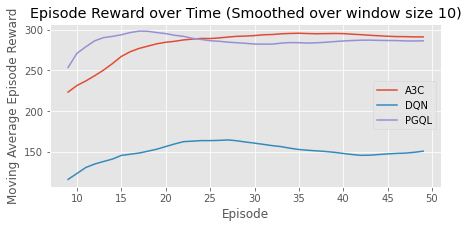

In [9]:
UPDATE_GLOBAL_ITER = 32
local_update_iter=8
MAX_EP = 50
discount_factor = 0.99
learning_rate = 2e-4
epsilon=0.1
env_name='ALE/Assault-ram-v5'
if __name__ == '__main__':
    #mp.set_start_method('spawn',force='True')
    A3C_stats=async_adv_actor_crtic(env, discount_factor,UPDATE_GLOBAL_ITER, local_update_iter, MAX_EP, learning_rate,env_name)
    DQN_stats=async_deep_q_learning(env, discount_factor,UPDATE_GLOBAL_ITER,local_update_iter, MAX_EP, learning_rate,epsilon,env_name)
    PGQL_stats=async_PGQL(env, discount_factor,UPDATE_GLOBAL_ITER, local_update_iter,MAX_EP,learning_rate,env_name)
    print(A3C_stats,DQN_stats,PGQL_stats)
    env.close()
    plot_episode_reward(['A3C','DQN',"PGQL"],[A3C_stats,DQN_stats,PGQL_stats])

In [ ]:
UPDATE_GLOBAL_ITER = 32
local_update_iter=8
MAX_EP = 1e6
discount_factor = 0.99
learning_rate = 2e-4
epsilon=0.1
env_name='ALE/Assault-ram-v5'
overall_iter=100
A3C_rewards=[]
DQN_rewards=[]
PGQL_rewards=[]
if __name__ == '__main__':
    #mp.set_start_method('spawn',force='True')
    for i in range(overall_iter):
        A3C_stats=async_adv_actor_crtic(env, discount_factor,UPDATE_GLOBAL_ITER, local_update_iter, MAX_EP, learning_rate,env_name)
        DQN_stats=async_deep_q_learning(env, discount_factor,UPDATE_GLOBAL_ITER,local_update_iter, MAX_EP, learning_rate,epsilon,env_name)
        PGQL_stats=async_PGQL(env, discount_factor,UPDATE_GLOBAL_ITER, local_update_iter,MAX_EP,learning_rate,env_name)
        print(A3C_stats)#,DQN_stats,PGQL_stats)
        
        A3C_rewards.append(A3C_stats)
        DQN_rewards.append(DQN_stats)
        PGQL_rewards.append(PGQL_rewards)
    A3C_stats=np.mean(A3C_rewards,axis=0)
    DQN_stats=np.mean(DQN_rewards,axis=0)
    PGQL_stats=np.mean(PGQL_rewards,axis=0)
    print(A3C_stats,DQN_stats,PGQL_stats)
    env.close()
    plot_episode_reward(['A3C','DQN',"PGQL"],[A3C_stats,DQN_stats,PGQL_stats])